# all of this code is taken from the amazing Kernel of Awsaf :  

https://www.kaggle.com/awsaf49

https://www.kaggle.com/awsaf49/happywhale-boundingbox-yolov5

In [12]:
!pip install -qU wandb
!pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code
!pip install -q imagesize

In [13]:
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import imagesize
import shutil

from joblib import Parallel, delayed


In [14]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient

    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous="must")
    print(
        "To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize"
    )


wandb: Currently logged in as: anony-mouse-243443 (use `wandb login --relogin` to force relogin)


To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [15]:
FOLD = 1  # which fold to train
DIM = 512
MODEL = "yolov5x"
BATCH = 24
EPOCHS = 25
OPTMIZER = "SGD"

PROJECT = "happywhale-det-public"  # w&b in yolov5
NAME = f"{MODEL}-dim{DIM}-fold{FOLD}_test01_allfin3"  # w&b for yolov5

ROOT_DIR = "train_images"
IMAGE_DIR = "data1/images"  # directory to save images
LABEL_DIR = "data1/labels"  # directory to save labels
WORKING_DIR = "working"
INPUT_DIR = "input"
SRC_DIR = "src"


## Create Directories

In [16]:
mv ./kaggle.json /root/.kaggle/kaggle.json

In [17]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}
!mkdir -p {WORKING_DIR}
!mkdir -p {INPUT_DIR}
!mkdir -p {SRC_DIR}

In [18]:
!kaggle datasets download jpbremer/backfin-annotations

  0% 0.00/88.7k [00:00<?, ?B/s]
100% 88.7k/88.7k [00:00<00:00, 52.8MB/s]


In [19]:
!unzip backfin-annotations.zip

Archive:  backfin-annotations.zip
  inflating: backfin_annotations.csv  


In [20]:
! kaggle competitions download happy-whale-and-dolphin 

100% 57.7G/57.7G [08:05<00:00, 127MB/s]
100% 57.7G/57.7G [08:05<00:00, 127MB/s]


In [ ]:
! unzip happy-whale-and-dolphin.zip

## Get Paths

In [22]:
# Train Data
df = pd.read_csv("backfin_annotations.csv")
df.columns = ["image_id", "x", "y", "w", "h"]
df["old_image_path"] = f"{ROOT_DIR}/" + df.image_id.astype(str)
df["image_path"] = f"{IMAGE_DIR}/" + df.image_id
df["label_path"] = f"{LABEL_DIR}/" + df.image_id.str.replace("jpg", "txt")
df.head(2)


,image_id,x,y,w,h,old_image_path,image_path,label_path
0,00021adfb725ed.jpg,0,113,804,512,train_images/00021adfb725ed.jpg,data1/images/00021adfb725ed.jpg,data1/labels/00021adfb725ed.txt
1,000562241d384d.jpg,1625,552,1020,359,train_images/000562241d384d.jpg,data1/images/000562241d384d.jpg,data1/labels/000562241d384d.txt


In [23]:
def make_copy(row):
    shutil.copyfile(row.old_image_path, row.image_path)
    return

In [24]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

  0%|          | 0/5201 [00:00<?, ?it/s]

In [25]:
os.listdir("data1")

['images', 'labels']

In [26]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo, yolo2voc
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [27]:
def x2bbox(points):
    xmin, ymin, xmax, ymax = points.split(" ")#points.split(" ")points[:, 0].min(), points[:, 1].min(), points[:, 0].max(), points[:, 1].max()
    xmin, ymin,xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    xmax = xmin + xmax
    ymax = ymin + ymax
    return [[xmin, ymin, xmax, ymax]]

In [28]:
df["bbox"] = df["x"].astype(str) + " " +  df["y"].astype(str) + " " + df["w"].astype(str) + " " + df["h"].astype(str)
df['bbox'] = df.bbox.map(x2bbox)

In [29]:
df = df.progress_apply(get_imgsize, axis=1)
display(df.head(2))

  0%|          | 0/5201 [00:00<?, ?it/s]

,image_id,x,y,w,h,old_image_path,image_path,label_path,bbox,width,height
0,00021adfb725ed.jpg,0,113,804,512,train_images/00021adfb725ed.jpg,data1/images/00021adfb725ed.jpg,data1/labels/00021adfb725ed.txt,"[[0, 113, 804, 625]]",804,671
1,000562241d384d.jpg,1625,552,1020,359,train_images/000562241d384d.jpg,data1/images/000562241d384d.jpg,data1/labels/000562241d384d.txt,"[[1625, 552, 2645, 911]]",3504,2336


In [30]:
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width = row.width
    bboxes_voc = np.array(row.bbox).astype(np.float32).copy()
    num_bbox = len(bboxes_voc)
    names = ["whale"] * num_bbox
    labels = np.array([0] * num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, "w") as f:
        if num_bbox < 1:
            annot = ""
            f.write(annot)
            cnt += 1
            continue
        #         bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id]] * len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print("Missing:", cnt)


  0%|          | 0/5201 [00:00<?, ?it/s]

Missing: 0


In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=6, random_state=42, shuffle=True)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    df.loc[val_idx, 'fold'] = fold
df.fold.value_counts()

2    867
4    867
0    867
1    867
3    867
5    866
Name: fold, dtype: int64

In [32]:
df = df[(df["x"] > 0) & (df["y"] > 0) & (df["w"] > 0) & (df["h"] > 0)].reset_index(drop = True)

In [33]:
bbox_df = pd.DataFrame(np.concatenate([bboxes_info, all_bboxes], axis=1),
             columns=['image_id','xmid','ymid','w','h'])
bbox_df[['xmid','ymid','w','h']] = bbox_df[['xmid','ymid','w','h']].astype(float)
bbox_df['area'] = bbox_df.w * bbox_df.h
bbox_df = bbox_df.merge(df[['image_id','fold']], on='image_id', how='left')
bbox_df.head(2)

,image_id,xmid,ymid,w,h,area,fold
0,00021adfb725ed.jpg,0.500000,0.549925,1.000000,0.763040,0.763040,NaN
1,000562241d384d.jpg,0.609304,0.313142,0.291096,0.153682,0.044736,4.0


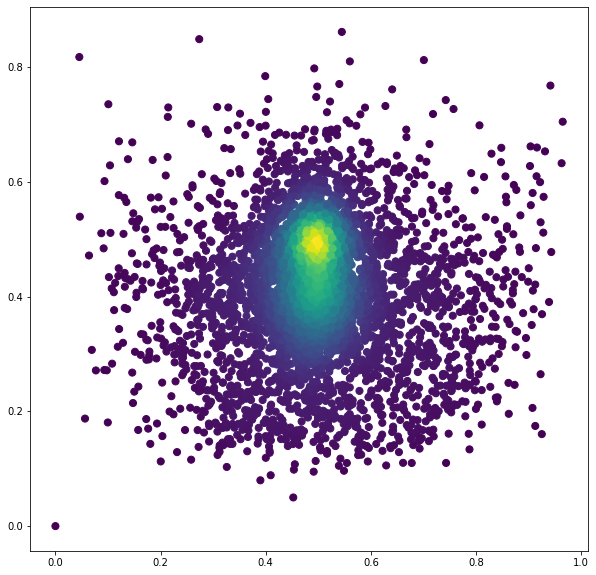

In [34]:
from scipy.stats import gaussian_kde

all_bboxes = np.array(all_bboxes)

x_val = all_bboxes[...,0]
y_val = all_bboxes[...,1]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=50, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

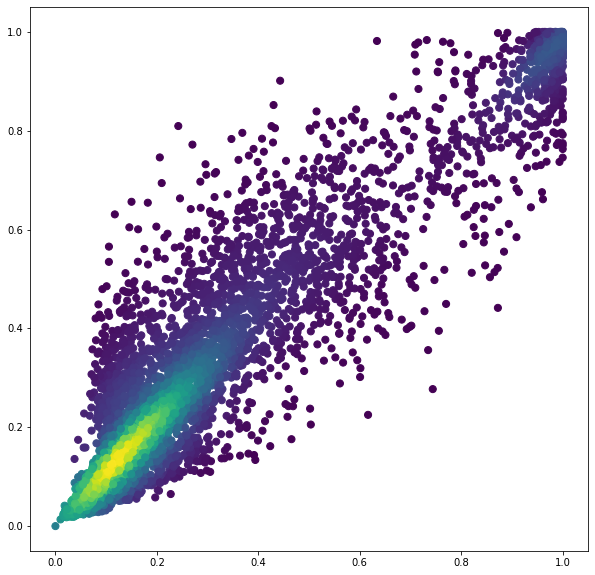

In [35]:
x_val = all_bboxes[...,2]
y_val = all_bboxes[...,3]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=50, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


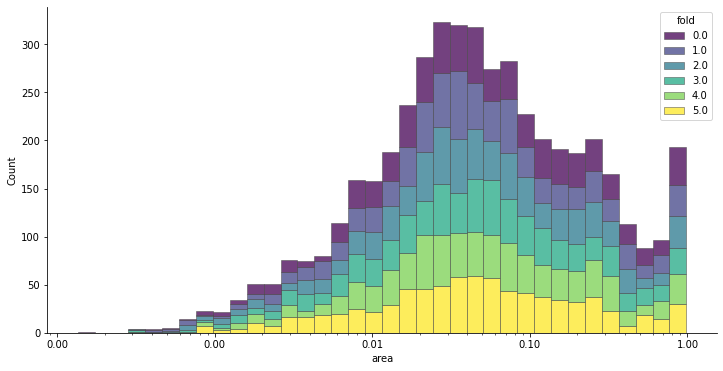

In [36]:
import matplotlib as mpl
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)

sns.histplot(
    bbox_df,
    x="area", hue="fold",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

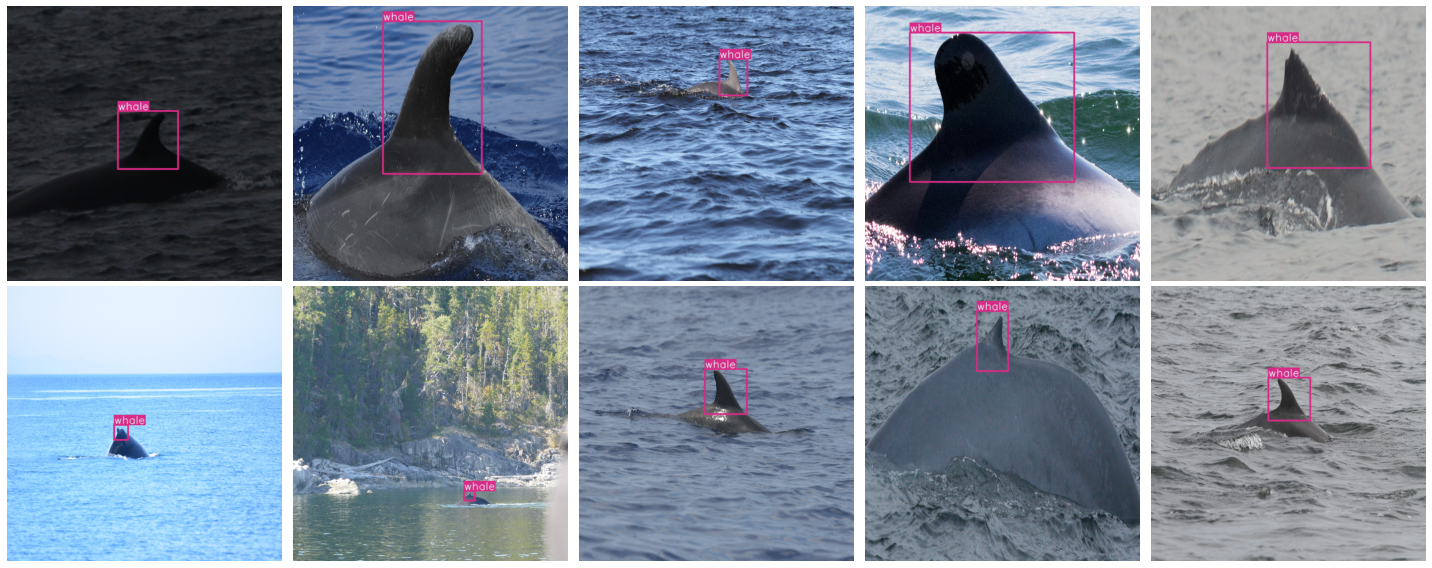

In [37]:
df2 = df.sample(100) # takes samples with bbox
y = 2
x = 5
plt.figure(figsize=(4 * x, 4 * y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    img           = cv2.resize(img, (512, 512))
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['whale']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

In [38]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

(3976, 789)

In [39]:
import yaml

cwd = 'working'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = cwd,
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['whale'],
    )

with open(os.path.join( cwd , 'happywhale.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'happywhale.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- whale
nc: 1
path: working
train: working/train.txt
val: working/val.txt



In [40]:
%%writefile working/hyp.yaml
lr0: 0.05  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 30.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.75  # image scale (+/- gain)
shear: 10.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.05  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.75  # image mosaic (probability)
mixup: 0.0 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Writing working/hyp.yaml


In [83]:
os.chdir('test_images')
ls
%cd working
!rm -r yolov5
#!git clone https://github.com/ultralytics/yolov5 # clone
#!cp -r input/yolov5-lib-ds working/yolov5
!cp -r input/happywhale-boundingbox-yolov5-ds/yolov5 working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
_ = utils.notebook_init()


FileNotFoundError: ignored

In [61]:
!python train.py --img {DIM}\
--batch {BATCH}\
--epochs {EPOCHS}\
--optimizer {OPTMIZER}\
--data working/happywhale.yaml\
--hyp working/hyp.yaml\
--weights {MODEL}.pt\
--project {PROJECT} --name {NAME}\
--exist-ok

wandb: Currently logged in as: anony-mouse-243443 (use `wandb login --relogin` to force relogin)
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE] [--imgsz IMGSZ]
                [--rect] [--resume [RESUME]] [--nosave] [--noval]
                [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--bucket BUCKET] [--cache [CACHE]] [--image-weights]
                [--device DEVICE] [--multi-scale] [--single-cls]
                [--optimizer {SGD,Adam,AdamW}] [--sync-bn] [--workers WORKERS]
                [--project PROJECT] [--name NAME] [--exist-ok] [--quad]
                [--cos-lr] [--label-smoothing LABEL_SMOOTHING]
                [--patience PATIENCE] [--freeze FREEZE [FREEZE ...]]
                [--save-period SAVE_PERIOD] [--local_rank LOCAL_RANK]
                [--entity ENTITY] [--upload_dataset [UPLOAD_DATASET]]
                [--bbox_interval BBOX_INTERVAL]
           

In [62]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)
!ls {OUTPUT_DIR}

ls: cannot access 'happywhale-det-public/yolov5x-dim512-fold1_test01_allfin3': No such file or directory


In [63]:
!ls {OUTPUT_DIR}/weights/best.pt

ls: cannot access 'happywhale-det-public/yolov5x-dim512-fold1_test01_allfin3/weights/best.pt': No such file or directory


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch2.jpg'))

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

In [ ]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'));
    plt.show()

In [ ]:
class CFG:
    seed = 42
    base_path = '/kaggle/input/happy-whale-and-dolphin'

In [ ]:
train_output = '/kaggle/working/output/train'
test_output = '/kaggle/working/output/test'

In [ ]:
df2 = pd.read_csv(f"/kaggle/input/happywhale-data-distribution/train.csv")
df2["image_id"] = df2["image"]
df2["label_path"] = train_output + "/labels/" + df2["image_id"].str.replace('jpg','txt')


test_df2 = pd.read_csv(f"/kaggle/input/happywhale-data-distribution/test.csv")
test_df2["image_id"] = test_df2["image"]
test_df2["label_path"] = test_output + "/labels/" + test_df2["image_id"].str.replace('jpg','txt')

print("Train Images: {:,} | Test Images: {:,}".format(len(df2), len(test_df2)))


In [ ]:
!rm -rf {train_output}
!mkdir -p {train_output}

In [ ]:
!python detect.py --img {DIM}\
--source /kaggle/input/happy-whale-and-dolphin/train_images\
--weights {OUTPUT_DIR}/weights/best.pt\
--project /kaggle/working/output --name train\
--conf 0.01 --iou 0.4 --max-det 1\
--save-txt --save-conf\
--nosave\
--half\
--exist-ok

In [ ]:
! pip install --upgrade pip
! pip install elegy datasets matplotlib
# For GPU install proper version of your CUDA, following will work in colab:
# ! pip install --upgrade jax jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html


In [ ]:
original_dataset_dir = 'train_images'
base_dir = "dolphin_images"
if not os.path.exists(base_dir):
  os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
  os.mkdir(test_dir)

train_whales_dir = os.path.join(train_dir, 'whales')
if not os.path.exists(train_whales_dir):
  os.mkdir(train_whales_dir)

validation_whales_dir = os.path.join(validation_dir, 'whales')
if not os.path.exists(validation_whales_dir):
  os.mkdir(validation_whales_dir)

test_whales_dir = os.path.join(test_dir, 'whales')
if not os.path.exists(test_whales_dir):
  os.mkdir(test_whales_dir)

src = os.path.join(original_dataset_dir, f)
dst = os.path.join(train_whales_dir, jpg)
for i in range(1000):
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
from datasets.load import load_dataset
import numpy as np

dataset = load_dataset("train_images")
dataset.set_format("np")
X_train = np.stack(dataset["train"]["image"])[..., None]
y_train = dataset["train"]["label"]
X_test = np.stack(dataset["test"]["image"])[..., None]
y_test = dataset["test"]["label"]

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

In [ ]:
import jax.numpy as jnp
import jax

import elegy as eg

class MLP(eg.Module):
    def __init__(self, n1: int, n2: int):
        self.n1 = n1
        self.n2 = n2
    
    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x.astype(jnp.float32) / 255.0
        x = eg.nn.Flatten()(x)
        # first layers
        x = eg.nn.Linear(self.n1)(x)
        x = jax.nn.relu(x)
        # first layers
        x = eg.nn.Linear(self.n2)(x)
        x = jax.nn.relu(x)
        # output layer
        x = eg.nn.Linear(10)(x)
        
        return x

In [ ]:
import optax

model = eg.Model(
    module=MLP(n1=300, n2=100),
    loss=[
        eg.losses.Crossentropy(),
        eg.regularizers.L2(l=1e-4),
    ],
    metrics=eg.metrics.Accuracy(),
    optimizer=optax.adam(1e-3),
)

In [ ]:
history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=100,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[eg.callbacks.ModelCheckpoint("models/high-level", save_best_only=True)],
)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, label=f"Training {key}")
        plt.plot(val_metric, label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

In [ ]:
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}

# 💡 Reference
* [Humpback Whale Identification - Fluke Location](https://www.kaggle.com/martinpiotte/humpback-whale-identification-fluke-location)

<div align="center"><img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png" width=400>